In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import Word2Vec
from openTSNE import TSNE
from fdict import sfdict
from tqdm import tqdm

In [2]:
ngram_abstracts = np.load("files/ngram_abstracts_repl.npy", mmap_mode="r")
concept_arr = np.unique(np.load("files/overlapping_save_concepts.npy"))
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
month_arr = np.load("files/month_arr.npy", mmap_mode="r")

In [3]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr
df_ab["month_arr"] = month_arr

In [4]:
df_ab.head()

,ab,year,month_arr
0,it be outline the possibility to extend the qu...,2007,3
1,in a quantum mechanical model diosi feldmann a...,2007,4
2,a novel way of picture the processing of quant...,2008,5
3,we consider a single ion confine in a trap und...,2007,4
4,we show how a single trap_ion may be use to te...,2007,7


In [5]:
cores = multiprocessing.cpu_count()

w2v_model = Word2Vec(min_count=5,
                     window=8,
                     vector_size=200,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)

w2v_model.build_vocab([ab.split() for ab in df_ab[df_ab['year'] == int(1994)]["ab"].to_numpy()])
w2v_model.train([ab.split() for ab in df_ab[df_ab['year'] == int(1994)]["ab"].to_numpy()], total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
w2v_model.save("saved_models/model_year_{}.model".format(1994))
for year in np.unique(year_arr)[1:]:
   
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] == int(year)]["ab"].to_numpy()]

    w2v_model.build_vocab(ngram_abstracts_year, progress_per=10000,update=True)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
    w2v_model.save("saved_models/model_year_{}.model".format(year))


First pass: Find all occurances of concepts individually & save them in a sfdict format.

In [35]:
c_dict = {}
cnt_0 = 0 
cnt_1 = 0
for year in tqdm(np.unique(year_arr)):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    for c in concept_arr:
        if c not in c_dict:
            c_dict[c] = {}

        if year in c_dict[c]:
            continue 
        else:

            try:
                vec_enc = loaded_w2v.wv.get_vector(c)
                c_dict[c][year] =  vec_enc
                cnt_0 +=1
                
            except: 
                cnt_1+=1
                pass
cnt_1,cnt_0

100%|██████████| 30/30 [00:02<00:00, 14.07it/s]


(198279, 71721)

In [38]:
c_sfdict = sfdict(c_dict, filename='files/concept_year_dict.db') 
c_sfdict.sync()  # synchronize all changes back to disk
c_sfdict.close()  # should always close a db

Second pass: Fill in empty entries: 

1994: empty 1995: empty 1996: encoding, then use same value as 1996 

1996: encoding_0 1997: empty 1998: encoding_1 use same value as 1998, i.e. always from right to left 

In [40]:
# takes about 12 mins
len_arr = []
len_new_arr = []
concept_inx_arr = []


for c in tqdm(concept_arr):
   
    l = len(c_dict[c])
    len_arr.append(l)
    
    if l > 0:
        concept_inx_arr.append(c)
        for success_inx, success_year in enumerate(np.unique(year_arr)): 
            if success_year in c_dict[c]:
                break
            
        for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
            if year not in c_dict[c]:
                c_dict[c][year] = c_dict[c][success_year]
            else:
                pass

    len_new_arr.append(len(c_dict[c]))
concept_inx_arr = np.array(concept_inx_arr)


100%|██████████| 9000/9000 [00:02<00:00, 3366.16it/s]


In [41]:
c_sfdict = sfdict(c_dict, filename='files/concept_year_dict_filled.db') 
c_sfdict.sync()  # synchronize all changes back to disk
c_sfdict.close()  # should always close a db

In [42]:
np.unique(len_new_arr,return_counts=True)

(array([ 0, 30]), array([2962, 6038]))

In [39]:
# takes about 60 mins
# for year in tqdm(np.unique(year_arr)):
        
#     c_dict = sfdict(filename='files/concept_year_dict_new.db')    
#     loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

#     for c in concept_arr:
#         if c not in c_dict:
#             c_dict[c] = {}

#         if year in c_dict[c]:
#             continue 
#         else:

#             try:
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] =  vec_enc
#             except: 
#                 pass


In [ ]:
# # takes about 12 mins
# len_arr = []
# len_new_arr = []
# concept_inx_arr = []

# c_dict = sfdict(filename='files/concept_year_dict_new.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     len_arr.append(l)
    
#     if l > 0:
#         concept_inx_arr.append(c)
#         for success_inx, success_year in enumerate(np.unique(year_arr)): 
#             if success_year in c_dict[c]:
#                 break
            
#         for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
#             if year not in c_dict[c]:
#                 c_dict[c][year] = c_dict[c][success_year]
#             else:
#                 pass

#     len_new_arr.append(len(c_dict[c]))
# concept_inx_arr = np.array(concept_inx_arr)
# c_dict.sync()  # synchronize all changes back to disk
# c_dict.close()  # should always close a db

100%|██████████| 9079/9079 [03:43<00:00, 40.69it/s]


In [125]:
# # check which concepts worked out

# len_new_arr = []


# c_dict = sfdict(filename='files/concept_year_dict.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     if l > 0:
        
#         len_new_arr.append(len(c_dict[c]))
    
# c_dict.close()  # should always close a db


100%|██████████| 11720/11720 [03:36<00:00, 54.19it/s]


Text(0.5, 1.0, 'metallic_film vs casimir_pressure')

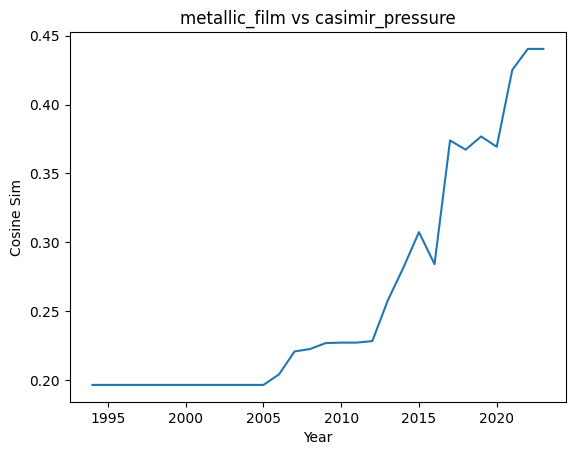

In [51]:

found = False
a_arr = []
while not found:
    c1=np.random.choice(concept_inx_arr)
    c2=np.random.choice(concept_inx_arr)

    zx_d = c_dict[c1]
    su_d = c_dict[c2]

    track_vec_bell_inequality = np.array([zx_d[i] for i in np.unique(year_arr)])
    track_vec_schroding_equation = np.array([su_d[i] for i in np.unique(year_arr)])

    def similarity_cosine(vec1, vec2):
        cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
        return cosine_similarity

    a = [similarity_cosine(v1, v2) for (v1,v2) in zip(track_vec_bell_inequality,track_vec_schroding_equation)]

    a_arr .append(a)
    if a[-1]>0.3:
        found = True 
        
plt.plot(np.unique(year_arr),a)
plt.ylabel("Cosine Sim")
plt.xlabel("Year")
plt.title(c1 + " vs "+c2)

array([ 2.4177900e-03,  5.9626613e-02,  3.3788404e-01, -5.0162353e-02,
       -1.0864983e-04,  6.9778512e-04,  5.4979805e-02, -1.6158734e-02,
        1.9595146e-01,  1.0945840e-01, -4.5570210e-02, -2.9085580e-02,
       -1.3316077e-01,  6.1457757e-02,  1.7665721e-02,  2.9766265e-02,
        7.2553433e-03, -6.1624512e-02, -4.2739514e-02, -2.0412173e-02,
       -2.7558936e-02,  4.5619726e-02,  1.6573021e-02,  2.6138386e-01],
      dtype=float32)

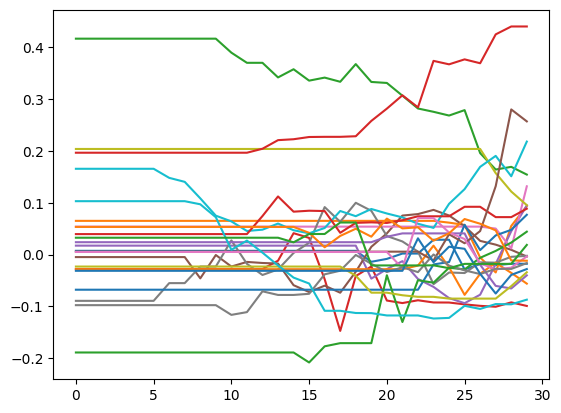

In [52]:
plt.plot(np.array(a_arr).T)
np.mean(np.array(a_arr),axis=-1)

Compress into lower dim space for ML model

In [54]:
# extract 100 concepts

c_dict_arr = []
for _ in range(100):
    c=np.random.choice(concept_inx_arr)
    c_d = c_dict[c]
    c_dict_arr.append(dict(sorted(c_d.items())))


In [56]:
np.concatenate(np.array([list(c.values()) for c in c_dict_arr])).shape

(3000, 200)

[0.09616193 0.08784785 0.07997797 0.07629015 0.05844821 0.05249042
 0.04166047 0.03703121]
[100.78708   96.33161   91.915436  89.77129   78.575806  74.46347
  66.338455  62.544228]


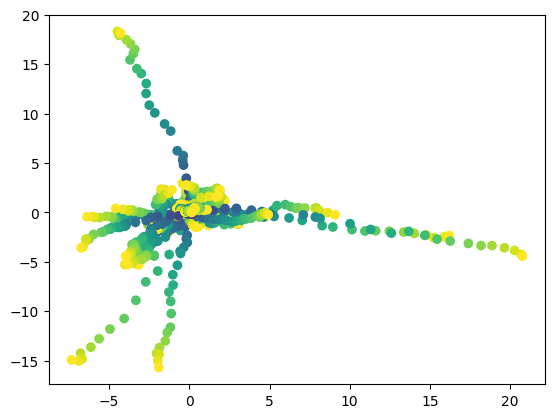

In [58]:

from sklearn.decomposition import PCA

pca = PCA(n_components=8)
embedding_bell_inequality = pca.fit_transform(np.concatenate(np.array([list(c.values()) for c in c_dict_arr])))
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# tsne = TSNE(
#     early_exaggeration_iter=10,
#     n_iter=2000,
#     random_state=42,
#     verbose=True
# )
# embedding_x = tsne.fit(np.concatenate(np.array([list(c.values()) for c in c_dict_arr])))

plt.scatter(embedding_bell_inequality[:,0],embedding_bell_inequality[:,1],c=list(np.unique(year_arr))*(embedding_bell_inequality.shape[0]//30))

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, early_exaggeration_iter=10, n_iter=2000,
     random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.27 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.07 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.03 seconds
===> Running optimization with exaggeration=12.00, lr=250.00 for 10 iterations...
   --> Time elapsed: 0.56 seconds
===> Running optimization with exaggeration=1.00, lr=3000.00 for 2000 iterations...
Iteration   50, KL divergence 0.4748, 50 iterations in 1.9003 sec
Iteration  100, KL divergence 0.3636, 50 iterations in 1.8355 sec
Iteration  150, KL divergence 0.3323, 50 iterations in 1.8763 sec
Iteration  200, KL divergence 0.3120, 50 iterations in 1.87

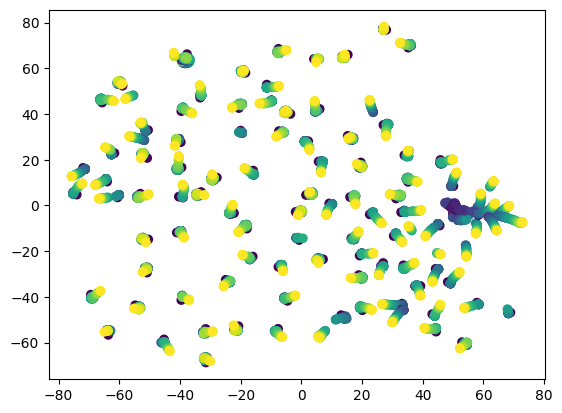

In [17]:
tsne = TSNE(
    early_exaggeration_iter=10,
    n_iter=2000,
    random_state=42,
    verbose=True
)
embedding_bell_inequality = tsne.fit(np.concatenate(np.array([list(c.values()) for c in c_dict_arr])))

plt.scatter(embedding_bell_inequality[:,0],embedding_bell_inequality[:,1],c=list(np.unique(year_arr))*(embedding_bell_inequality.shape[0]//30))